# 0. Import library
- 필요한 라이브러리를 import합니다
- 실험 재현을 위한 랜덤시드 고정

In [1]:
import numpy as np
import pandas as pd 
import os

import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import torch.backends.cudnn as cudnn
from PIL import Image 
import torch.nn as nn
from tqdm.auto import tqdm
import cv2
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.autograd import Variable
from datetime import datetime



def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    cudnn.benchmark = False
#실험 재현을 위한 랜덤시드 고정
set_seed(42)

/home/eslab/anaconda3/envs/nyh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#본인 환경에 맞는 데이터들이 있는 폴더의 위치를 입력 
os.chdir('./')
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from thop import profile
# timm.list_models()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 2. Preparing Dataset and Dataloader

In [ ]:
model_score = pd.read_csv('timm_Model_Score.csv', encoding = 'cp949')
model_score = model_score[['model', 'loss', 'accuracy', 'gflops', 'type_Arch', 'type_training']]

for i, e in enumerate(model_score.index):
    if model_score.loc[i]['gflops'] > 10: model_score.drop(index=i, inplace = True)
    elif model_score.loc[i]['loss'] > 1:model_score.drop(index=i, inplace = True)

model_score 

,model,loss,accuracy,gflops,type_Arch,type_training
0,nf_resnet101,0.102800,0.687627,0.000940,Normalizer-Free,resnet
1,nf_resnet50,0.294613,0.409793,0.000940,Normalizer-Free,resnet
2,nf_resnet26,0.044247,0.851974,0.000940,Normalizer-Free,resnet
3,nf_ecaresnet26,0.036818,0.862728,0.001033,Normalizer-Free,Efficient Channel Attention
4,nf_ecaresnet50,0.031268,0.884489,0.001116,Normalizer-Free,Efficient Channel Attention
...,...,...,...,...,...,...
241,tnt_s_patch16_224,0.089737,0.729504,9.683116,None,None
242,tnt_s_patch16_224,0.066089,0.774292,9.683116,None,None
243,xception41p,0.048184,0.834767,9.934474,None,None
244,cspdarknet53,0.056398,0.825658,9.945403,None,None


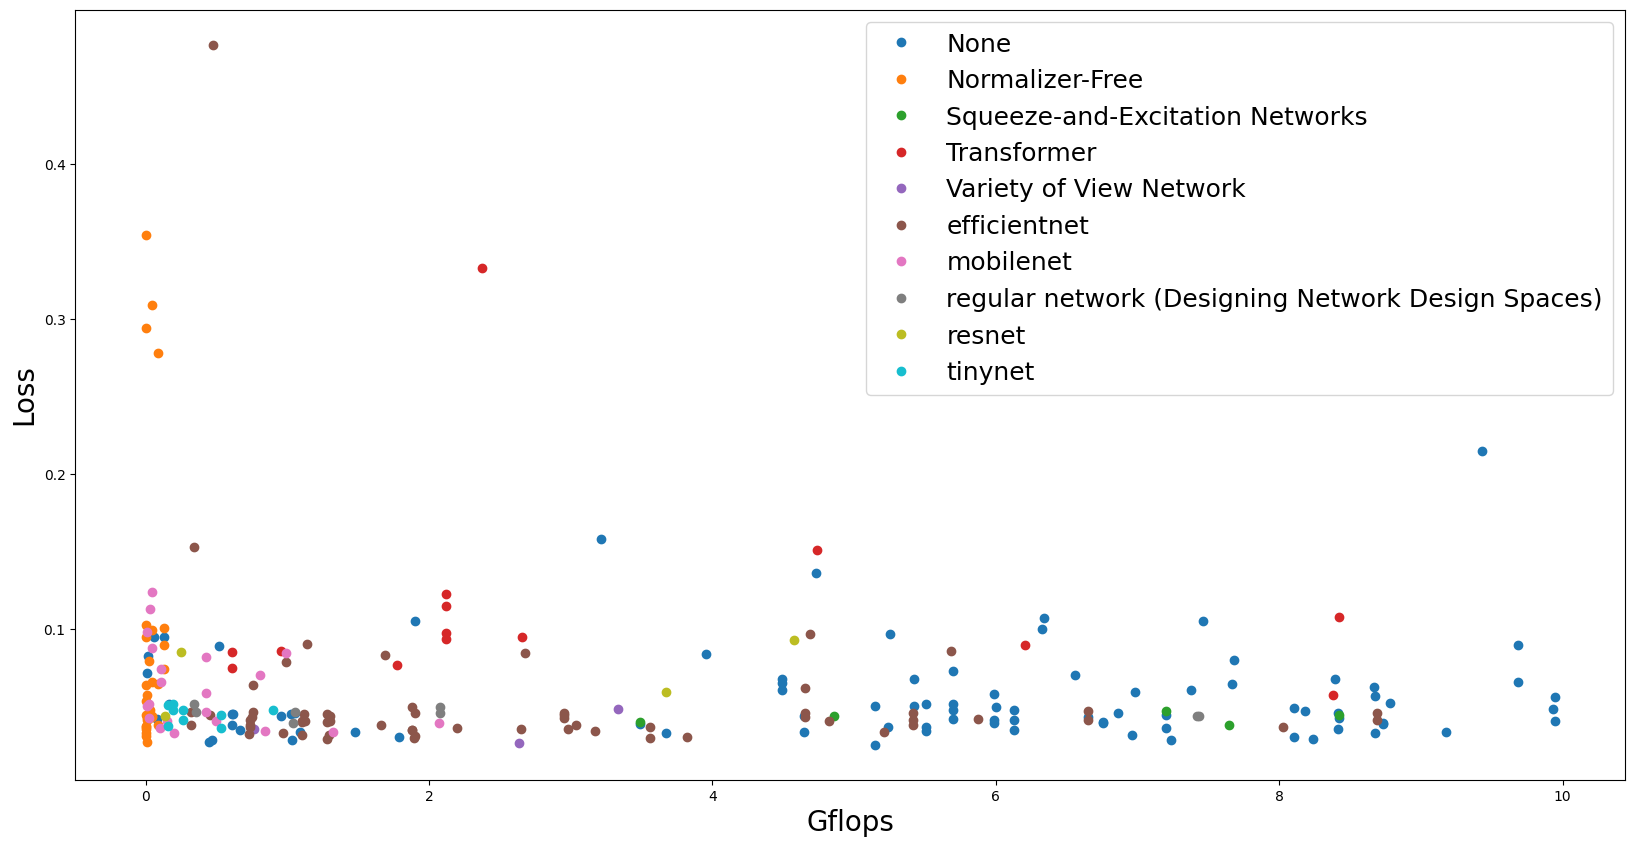

In [ ]:
groups = model_score.groupby('type_Arch')

fig, ax = plt.subplots(figsize = (20,10))

for name, group in groups:
    ax.plot(group.gflops, group.loss, marker='o', linestyle='', label=name)

ax.legend(fontsize=18, loc='upper right') # legend position

plt.xlabel('Gflops', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.show()

##### 원래 목표는 Efficientnet을 사용하지 않고 성능을 올리는 것이 목표.
##### 하지만 실험을 한 timm 모델 300개를 정렬하면 상위권은 대부분 EfficientNet이 차지하고 있으며,
##### 그래프를 그려보면 갈색 그림의 EfficientNet이 정확도 상위권은  계열
-> Loss 및 gflops 좋은 성능을 보여주는 주황색 계열의 모델로 성능을 내보겠다고 생각.

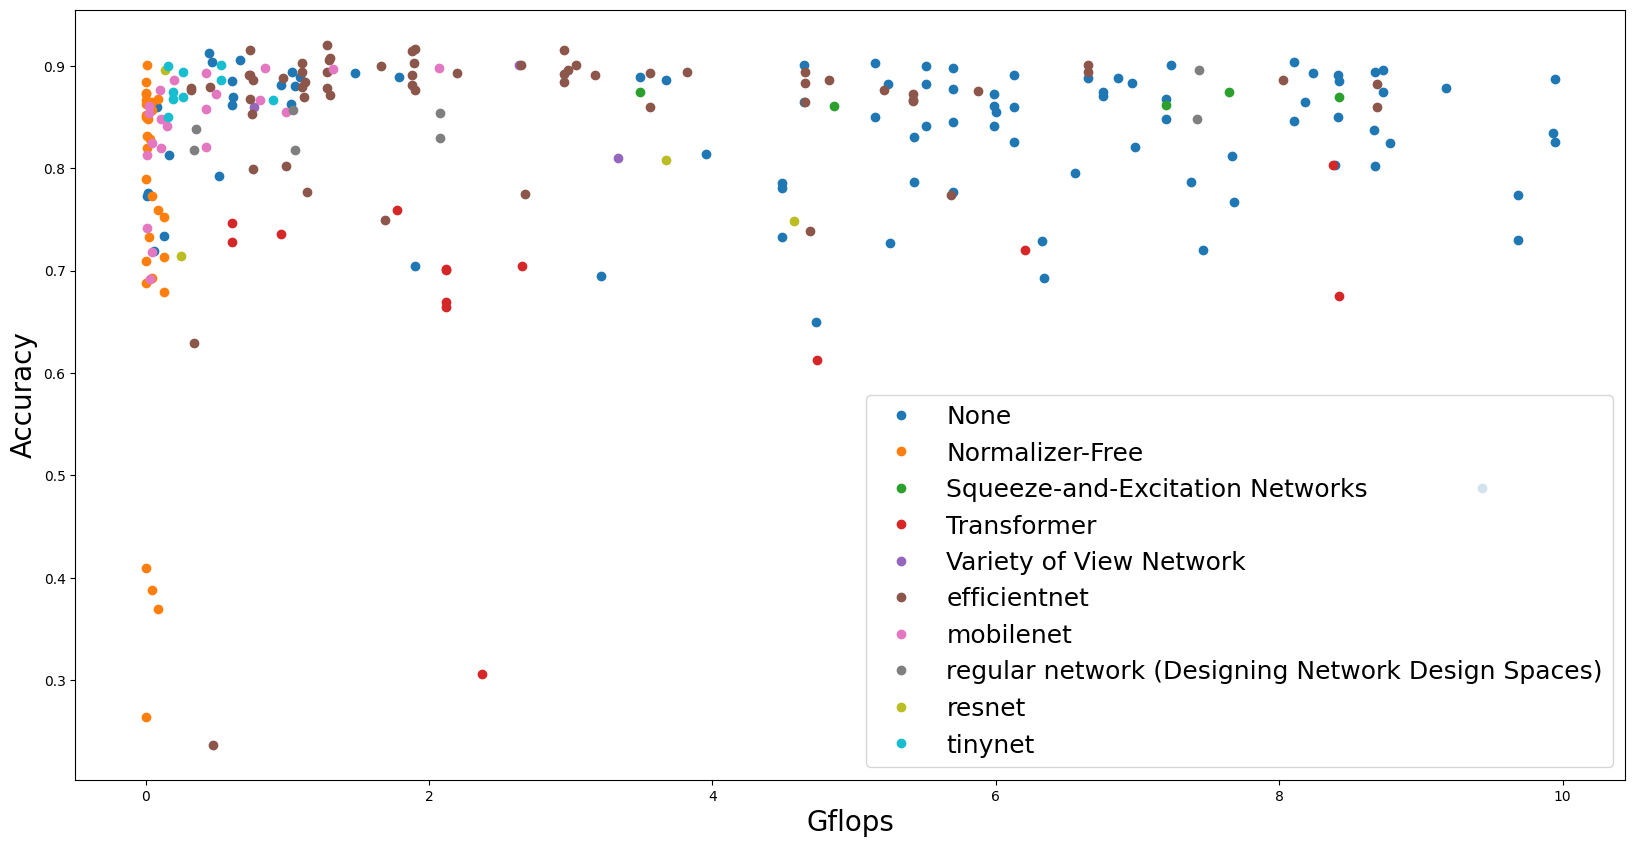

In [ ]:
groups = model_score.groupby('type_Arch')

fig, ax = plt.subplots(figsize = (20,10))

for name, group in groups:
    ax.plot(group.gflops, group.accuracy, marker='o', linestyle='', label=name)

ax.legend(fontsize=18, loc='lower right') # legend position

plt.xlabel('Gflops', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.show()

In [4]:
# train.csv를 가져와 train,validation dataset으로 분리
df = pd.read_csv('./train.csv')
train_df, val_df, _, _ = train_test_split(df, df['Plane'].values, test_size=0.2, shuffle=True, stratify=df['Plane'].values, random_state=34)
train_df.head()

,Image_name,Plane
1488,Patient00789_Plane6_5_of_7,5
529,Patient00705_Plane2_1_of_2,0
5054,Patient01114_Plane6_1_of_2,5
5221,Patient01135_Plane6_1_of_1,5
2778,Patient00855_Plane1_25_of_39,7


In [5]:
# 데이터 경로를 리턴해주는 함수를 통해 이미지 경로 추출
def get_data(df, test = False):
    if test is True:
        return "./test/"+df['Image_name'].values
    return "./train/"+df['Image_name'].values+'.png', df['Plane'].values

train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels=None, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        # image = Image.open(img_path).convert('RGB')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_paths)


In [7]:
def cutmix(data, targets, alpha=1.0):
    '''
    alpha 값을 1.0으로 설정하여 beta 분포가 uniform 분포가 되도록 함으로써, 
    두 이미지를 랜덤하게 combine하는 Cutmix
    '''
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = (targets, shuffled_targets, lam)
    
    return data, targets

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1

    if use_cuda: index = torch.randperm(x.size()[0]).cuda()
    else: index = torch.randperm(x.size()[0])

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

class CutMixCriterion:
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss().to(device)

    def __call__(self, preds, targets):
        targets1, targets2, lam = targets
        return lam * self.criterion(preds, targets1) + (1 - lam) * self.criterion(preds, targets2)

def knowledge_distillation_loss(logits, labels, loss_func, teacher_logits):
    alpha = 0.1
    T = 10
    
    # student_loss = F.cross_entropy(input=logits, target=labels)
    student_loss = loss_func(logits, labels)
    distillation_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(logits/T, dim=1), F.softmax(teacher_logits/T, dim=1)) * (T * T)
    total_loss =  alpha*student_loss + (1-alpha)*distillation_loss

    return total_loss

# 3. Selecting model, Cost(Loss) Function, and Optimizer
-> 아래의 def train() 내부에서 정의함

# 4. Train and validate the configured model

In [10]:
def make_time_dir(start_time):
    try:
        if not os.path.exists("./Save_model/" + start_time):
            os.makedirs("./Save_model/" + start_time)
    except:
        print("ERROR")

## 4-1 Teacher Model training 

In [ ]:
from einops import reduce
from tqdm.auto import tqdm, trange
import timm
from efficientnet_pytorch import EfficientNet

def train(transform, transform_val, model_name, batchsize = 16):
    set_seed(42)  #실험 재현을 위한 랜덤시드 고정
    
    train_img_paths, train_labels = get_data(df)
    train_dataset = CustomDataset(train_img_paths, train_labels, transforms = transform)
    train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True, num_workers=4)

    n_epochs = 80
    
    # model_name = "tf_efficientnetv2_l" # 91.48
    # model_name = "tf_efficientnet_b2_ns" # 0.9130
    # model_name = "ens_adv_inception_resnet_v2" 90.57
    model = EfficientNet.from_pretrained(model_name, num_classes=8, in_channels = 1).to(device)


    criterion = nn.CrossEntropyLoss()
    train_criterion = CutMixCriterion()
    optimizer = optim.AdamW(model.parameters(),lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    valid_loss_min = np.Inf # track change in validation loss
    valid_acc_max = 0 # track change in validation loss

    # keep track of training and validation loss
    train_loss, valid_loss = torch.zeros(n_epochs), torch.zeros(n_epochs)
    train_acc, valid_acc = torch.zeros(n_epochs), torch.zeros(n_epochs)

    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model.to(device)

    early_stopcount = 0

    for e in range(0, n_epochs):
        model.train()
        for data, labels in tqdm(train_loader):

            data = reduce(data, 'b (c c1) h w -> b c h w', 'mean', c1=3)
            data, labels = data.float().to(device), labels.to(device)  # move tensors to GPU if CUDA is available           
            optimizer.zero_grad() # clear the gradients of all optimized variables
            logits = model(data) # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss[e] += loss.item() # update training loss
            
        train_loss[e] /= len(train_loader)
        scheduler.step(train_loss[e])    

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            e, train_loss[e], 0))
        
        if train_loss[e] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            train_loss[e]))
            torch.save(model.module.state_dict(), './Save_model/' + model_name + 'F.pt') #모델파일이 저장되고자하는 경로 지정
            valid_loss_min = train_loss[e]
            early_stopcount = 0

        if early_stopcount >= 5: break

        early_stopcount+=1
    print(valid_loss_min)

In [ ]:
transform1 = A.Compose([
    A.Resize(width = 256, height = 256),
    A.RandomCrop(width = 224, height = 224),
    A.FancyPCA(p = 0.5),
    A.Rotate(limit=15),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std= [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

transform_val = A.Compose([
    A.Resize(width = 224, height = 224),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std = [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

li = [transform1]
model_lists = ['efficientnet-b3', 'efficientnet-b4']

for i, tf in enumerate(li):
    for e, model_list in enumerate(model_lists):
        print(f"{i}th {e}=========================================")
        print(model_list)
        train(transform = tf, transform_val = transform_val, model_name = model_list)

0th 0=========================================
efficientnet-b3
Loaded pretrained weights for efficientnet-b3


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 0 	Training Loss: 0.798936 	Validation Loss: 0.000000
Validation ACC increased (inf --> 0.798936).  Saving model ...


100%|██████████| 378/378 [02:14<00:00,  2.80it/s]


Epoch: 1 	Training Loss: 0.479014 	Validation Loss: 0.000000
Validation ACC increased (0.798936 --> 0.479014).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 2 	Training Loss: 0.379480 	Validation Loss: 0.000000
Validation ACC increased (0.479014 --> 0.379480).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.76it/s]


Epoch: 3 	Training Loss: 0.338177 	Validation Loss: 0.000000
Validation ACC increased (0.379480 --> 0.338177).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 4 	Training Loss: 0.305846 	Validation Loss: 0.000000
Validation ACC increased (0.338177 --> 0.305846).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.80it/s]


Epoch: 5 	Training Loss: 0.282524 	Validation Loss: 0.000000
Validation ACC increased (0.305846 --> 0.282524).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 6 	Training Loss: 0.244016 	Validation Loss: 0.000000
Validation ACC increased (0.282524 --> 0.244016).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 7 	Training Loss: 0.238257 	Validation Loss: 0.000000
Validation ACC increased (0.244016 --> 0.238257).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 8 	Training Loss: 0.221922 	Validation Loss: 0.000000
Validation ACC increased (0.238257 --> 0.221922).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.80it/s]


Epoch: 9 	Training Loss: 0.192697 	Validation Loss: 0.000000
Validation ACC increased (0.221922 --> 0.192697).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 10 	Training Loss: 0.184680 	Validation Loss: 0.000000
Validation ACC increased (0.192697 --> 0.184680).  Saving model ...


100%|██████████| 378/378 [02:14<00:00,  2.80it/s]


Epoch: 11 	Training Loss: 0.177947 	Validation Loss: 0.000000
Validation ACC increased (0.184680 --> 0.177947).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.78it/s]


Epoch: 12 	Training Loss: 0.163429 	Validation Loss: 0.000000
Validation ACC increased (0.177947 --> 0.163429).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.78it/s]


Epoch: 13 	Training Loss: 0.154130 	Validation Loss: 0.000000
Validation ACC increased (0.163429 --> 0.154130).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 14 	Training Loss: 0.144235 	Validation Loss: 0.000000
Validation ACC increased (0.154130 --> 0.144235).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 15 	Training Loss: 0.144493 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:13<00:00,  2.82it/s]


Epoch: 16 	Training Loss: 0.129387 	Validation Loss: 0.000000
Validation ACC increased (0.144235 --> 0.129387).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.78it/s]


Epoch: 17 	Training Loss: 0.134317 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 18 	Training Loss: 0.117029 	Validation Loss: 0.000000
Validation ACC increased (0.129387 --> 0.117029).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 19 	Training Loss: 0.120543 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 20 	Training Loss: 0.122866 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:15<00:00,  2.78it/s]


Epoch: 21 	Training Loss: 0.100178 	Validation Loss: 0.000000
Validation ACC increased (0.117029 --> 0.100178).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 22 	Training Loss: 0.094079 	Validation Loss: 0.000000
Validation ACC increased (0.100178 --> 0.094079).  Saving model ...


100%|██████████| 378/378 [02:17<00:00,  2.75it/s]


Epoch: 23 	Training Loss: 0.105780 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:13<00:00,  2.83it/s]


Epoch: 24 	Training Loss: 0.090292 	Validation Loss: 0.000000
Validation ACC increased (0.094079 --> 0.090292).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.80it/s]


Epoch: 25 	Training Loss: 0.096003 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.78it/s]


Epoch: 26 	Training Loss: 0.082756 	Validation Loss: 0.000000
Validation ACC increased (0.090292 --> 0.082756).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 27 	Training Loss: 0.087884 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.78it/s]


Epoch: 28 	Training Loss: 0.088103 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 29 	Training Loss: 0.091670 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:17<00:00,  2.75it/s]


Epoch: 30 	Training Loss: 0.071867 	Validation Loss: 0.000000
Validation ACC increased (0.082756 --> 0.071867).  Saving model ...


100%|██████████| 378/378 [02:14<00:00,  2.81it/s]


Epoch: 31 	Training Loss: 0.082860 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.78it/s]


Epoch: 32 	Training Loss: 0.084451 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:15<00:00,  2.78it/s]


Epoch: 33 	Training Loss: 0.072898 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 34 	Training Loss: 0.073488 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 35 	Training Loss: 0.071147 	Validation Loss: 0.000000
Validation ACC increased (0.071867 --> 0.071147).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.80it/s]


Epoch: 36 	Training Loss: 0.075970 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:15<00:00,  2.78it/s]


Epoch: 37 	Training Loss: 0.071450 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 38 	Training Loss: 0.068423 	Validation Loss: 0.000000
Validation ACC increased (0.071147 --> 0.068423).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 39 	Training Loss: 0.066031 	Validation Loss: 0.000000
Validation ACC increased (0.068423 --> 0.066031).  Saving model ...


100%|██████████| 378/378 [02:14<00:00,  2.80it/s]


Epoch: 40 	Training Loss: 0.070520 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 41 	Training Loss: 0.071117 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 42 	Training Loss: 0.052999 	Validation Loss: 0.000000
Validation ACC increased (0.066031 --> 0.052999).  Saving model ...


100%|██████████| 378/378 [02:15<00:00,  2.78it/s]


Epoch: 43 	Training Loss: 0.069248 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:15<00:00,  2.80it/s]


Epoch: 44 	Training Loss: 0.075655 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:17<00:00,  2.74it/s]


Epoch: 45 	Training Loss: 0.050871 	Validation Loss: 0.000000
Validation ACC increased (0.052999 --> 0.050871).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 46 	Training Loss: 0.049128 	Validation Loss: 0.000000
Validation ACC increased (0.050871 --> 0.049128).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.76it/s]


Epoch: 47 	Training Loss: 0.058566 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.78it/s]


Epoch: 48 	Training Loss: 0.071602 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 49 	Training Loss: 0.046040 	Validation Loss: 0.000000
Validation ACC increased (0.049128 --> 0.046040).  Saving model ...


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 50 	Training Loss: 0.048050 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.78it/s]


Epoch: 51 	Training Loss: 0.065570 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:15<00:00,  2.79it/s]


Epoch: 52 	Training Loss: 0.058611 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:16<00:00,  2.77it/s]


Epoch: 53 	Training Loss: 0.054560 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:17<00:00,  2.74it/s]


Epoch: 54 	Training Loss: 0.065463 	Validation Loss: 0.000000
tensor(0.0460)
0th 1=========================================
efficientnet-b4
Loaded pretrained weights for efficientnet-b4


100%|██████████| 378/378 [02:40<00:00,  2.36it/s]


Epoch: 0 	Training Loss: 0.757053 	Validation Loss: 0.000000
Validation ACC increased (inf --> 0.757053).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.32it/s]


Epoch: 1 	Training Loss: 0.447553 	Validation Loss: 0.000000
Validation ACC increased (0.757053 --> 0.447553).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 2 	Training Loss: 0.368524 	Validation Loss: 0.000000
Validation ACC increased (0.447553 --> 0.368524).  Saving model ...


100%|██████████| 378/378 [02:41<00:00,  2.34it/s]


Epoch: 3 	Training Loss: 0.324795 	Validation Loss: 0.000000
Validation ACC increased (0.368524 --> 0.324795).  Saving model ...


100%|██████████| 378/378 [02:41<00:00,  2.35it/s]


Epoch: 4 	Training Loss: 0.290081 	Validation Loss: 0.000000
Validation ACC increased (0.324795 --> 0.290081).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 5 	Training Loss: 0.263727 	Validation Loss: 0.000000
Validation ACC increased (0.290081 --> 0.263727).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.32it/s]


Epoch: 6 	Training Loss: 0.221248 	Validation Loss: 0.000000
Validation ACC increased (0.263727 --> 0.221248).  Saving model ...


100%|██████████| 378/378 [02:43<00:00,  2.31it/s]


Epoch: 7 	Training Loss: 0.218233 	Validation Loss: 0.000000
Validation ACC increased (0.221248 --> 0.218233).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.32it/s]


Epoch: 8 	Training Loss: 0.204399 	Validation Loss: 0.000000
Validation ACC increased (0.218233 --> 0.204399).  Saving model ...


100%|██████████| 378/378 [02:39<00:00,  2.37it/s]


Epoch: 9 	Training Loss: 0.186823 	Validation Loss: 0.000000
Validation ACC increased (0.204399 --> 0.186823).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 10 	Training Loss: 0.167682 	Validation Loss: 0.000000
Validation ACC increased (0.186823 --> 0.167682).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 11 	Training Loss: 0.160790 	Validation Loss: 0.000000
Validation ACC increased (0.167682 --> 0.160790).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 12 	Training Loss: 0.137795 	Validation Loss: 0.000000
Validation ACC increased (0.160790 --> 0.137795).  Saving model ...


100%|██████████| 378/378 [02:40<00:00,  2.35it/s]


Epoch: 13 	Training Loss: 0.146029 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:41<00:00,  2.33it/s]


Epoch: 14 	Training Loss: 0.139259 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:41<00:00,  2.34it/s]


Epoch: 15 	Training Loss: 0.122339 	Validation Loss: 0.000000
Validation ACC increased (0.137795 --> 0.122339).  Saving model ...


100%|██████████| 378/378 [02:41<00:00,  2.34it/s]


Epoch: 16 	Training Loss: 0.126145 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 17 	Training Loss: 0.106486 	Validation Loss: 0.000000
Validation ACC increased (0.122339 --> 0.106486).  Saving model ...


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 18 	Training Loss: 0.116536 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:42<00:00,  2.32it/s]


Epoch: 19 	Training Loss: 0.103423 	Validation Loss: 0.000000
Validation ACC increased (0.106486 --> 0.103423).  Saving model ...


100%|██████████| 378/378 [02:40<00:00,  2.36it/s]


Epoch: 20 	Training Loss: 0.095965 	Validation Loss: 0.000000
Validation ACC increased (0.103423 --> 0.095965).  Saving model ...


100%|██████████| 378/378 [02:40<00:00,  2.35it/s]


Epoch: 21 	Training Loss: 0.104052 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 22 	Training Loss: 0.086781 	Validation Loss: 0.000000
Validation ACC increased (0.095965 --> 0.086781).  Saving model ...


100%|██████████| 378/378 [02:41<00:00,  2.34it/s]


Epoch: 23 	Training Loss: 0.114710 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:41<00:00,  2.33it/s]


Epoch: 24 	Training Loss: 0.067863 	Validation Loss: 0.000000
Validation ACC increased (0.086781 --> 0.067863).  Saving model ...


100%|██████████| 378/378 [02:40<00:00,  2.35it/s]


Epoch: 25 	Training Loss: 0.081986 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:41<00:00,  2.34it/s]


Epoch: 26 	Training Loss: 0.083433 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 27 	Training Loss: 0.074644 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:42<00:00,  2.33it/s]


Epoch: 28 	Training Loss: 0.082901 	Validation Loss: 0.000000


100%|██████████| 378/378 [02:43<00:00,  2.32it/s]


Epoch: 29 	Training Loss: 0.072825 	Validation Loss: 0.000000
tensor(0.0679)


## 4-2 knowledge distillation을 사용하여 학습시키기.

In [ ]:
from einops import reduce
from tqdm.auto import tqdm, trange
import timm
from efficientnet_pytorch import EfficientNet

def train(transform, transform_val, model_name, batchsize = 16):

    start_time = str(datetime.now().date().year) + "_" + str(datetime.now().date().month) + "_" +  \
         str(datetime.now().date().day).zfill(2) + "_" + str(datetime.now().hour).zfill(2) + "_" + \
         str(datetime.now().minute).zfill(2) + "_" + str(datetime.now().second).zfill(2)
    make_time_dir(start_time=start_time)
    #실험 재현을 위한 랜덤시드 고정
    set_seed(42)

    train_img_paths, train_labels = get_data(train_df)
    val_img_paths, val_labels = get_data(val_df)
    
    train_dataset = CustomDataset(train_img_paths, train_labels, transforms = transform)
    train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True, num_workers=4, drop_last = True)
    val_dataset = CustomDataset(val_img_paths, val_labels, transforms = transform_val)
    val_loader = DataLoader(val_dataset, batch_size = batchsize, shuffle=True, num_workers=4)

    n_epochs = 100
    
    model = EfficientNet.from_pretrained("efficientnet-b4", num_classes=8, in_channels = 1).to(device)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model).to(device)
    model.module.load_state_dict(torch.load('./Save_model/efficientnet-b4F.pt'))
    model = model.to(device)

    student_model = timm.create_model(model_name, num_classes = 8, in_chans = 1, pretrained=True).to(device)
    if torch.cuda.device_count() > 1: 
        student_model = nn.DataParallel(student_model).to(device)

    criterion = nn.CrossEntropyLoss()
    train_criterion = CutMixCriterion()
    optimizer = optim.AdamW(student_model.parameters(),lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    valid_loss_min = np.Inf # track change in validation loss
    valid_acc_max = 0 # track change in validation loss

    # keep track of training and validation loss
    train_loss, valid_loss = torch.zeros(n_epochs), torch.zeros(n_epochs)
    train_acc, valid_acc = torch.zeros(n_epochs), torch.zeros(n_epochs)

    early_stopcount = 0

    for e in range(0, n_epochs):
        student_model.train()   
        for data, labels in tqdm(train_loader):
            rand_num = np.random.rand()
            
            if rand_num > 0.75: data, (target1, target2, lam) = cutmix(data, labels)
            elif rand_num > 0.5: 
                data, target1, target2, lam = mixup_data(data, labels)
                data, target1, target2 = map(Variable, (data, target1, target2))

            data = reduce(data, 'b (c c1) h w -> b c h w', 'mean', c1=3)
            data = data.float().to(device) # labels.to(device) # move tensors to GPU if CUDA is available     

            if rand_num > 0.5: labels = (target1.to(device), target2.to(device), lam)
            else: labels = labels.to(device)

            optimizer.zero_grad() # clear the gradients of all optimized variables
            student_outputs = student_model(data) # forward pass: compute predicted outputs by passing inputs to the model
            teacher_outputs = model(data)

            if rand_num > 0.5: total_loss = knowledge_distillation_loss(student_outputs, labels, train_criterion, teacher_outputs)
            else: total_loss = knowledge_distillation_loss(student_outputs, labels, criterion, teacher_outputs)

            total_loss.backward()
            optimizer.step()
                
            train_loss[e] += total_loss.item() # update training loss
            
        train_loss[e] /= len(train_loader)
        
        with torch.no_grad(): 
            student_model.eval()
            for data, labels in tqdm(val_loader):
                data = reduce(data, 'b (c c1) h w -> b c h w', 'mean', c1=3)
                data, labels = data.float().to(device), labels.to(device) # move tensors to GPU if CUDA is available
                
                logits = student_model(data) # forward pass: compute predicted outputs by passing inputs to the model
                loss = criterion(logits, labels)  # calculate the batch loss
                valid_loss[e] += loss.item()  # update average validation loss 
                
                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.reshape(top_class.shape)
                valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
                
        
        # calculate average losses
        valid_loss[e] /= len(val_loader)
        valid_acc[e] /= len(val_loader)
        
        scheduler.step(valid_loss[e])    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            e, train_loss[e], valid_loss[e]))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining accuracy: {} \tValidation accuracy: {:.6f}'.format(
            e, "No ACC in Train", valid_acc[e]))
        
        # save model if validation loss has decreased
        if valid_acc[e] >= valid_acc_max:
            print('Validation ACC increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_acc_max,
            valid_acc[e]))
            # torch.save(student_model.module.state_dict(), './Save_model/' + model_name + 'B.pt') #모델파일이 저장되고자하는 경로 지정
            torch.save(student_model.module.state_dict(), f"Save_model/{start_time}/fold{i}_{e:03}_Accuracy is {valid_acc[e]:4.2%}.pt")

            valid_acc_max = valid_acc[e]
            early_stopcount = 0

        if early_stopcount >= 10:
            break

        early_stopcount+=1
    print(valid_acc_max)

In [ ]:
transform11 = A.Compose([
    A.Resize(width = 284, height = 284),
    A.RandomCrop(width = 256, height = 256),
    A.FancyPCA(0.5),
    A.Rotate(limit=15),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std= [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

transform_val = A.Compose([
    A.Resize(width = 256, height = 256),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std = [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

li = [transform11]
model_lists = ['nf_regnet_b1']

for i, tf in enumerate(li):
    for e, model_list in enumerate(model_lists):
        print(f"{i}th {e}=========================================")
        train(transform = tf, transform_val = transform_val, model_name = model_list)

0th 0=========================================
Loaded pretrained weights for efficientnet-b4


100%|██████████| 38/38 [00:08<00:00,  4.45it/s]


Epoch: 0 	Training Loss: 4.235565 	Validation Loss: 0.671057
Epoch: 0 	Training accuracy: No ACC in Train 	Validation accuracy: 0.770243
Validation ACC increased (0.000000 --> 0.770243).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch: 1 	Training Loss: 2.516385 	Validation Loss: 0.585348
Epoch: 1 	Training accuracy: No ACC in Train 	Validation accuracy: 0.840714
Validation ACC increased (0.770243 --> 0.840714).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.54it/s]


Epoch: 2 	Training Loss: 1.816259 	Validation Loss: 0.402293
Epoch: 2 	Training accuracy: No ACC in Train 	Validation accuracy: 0.898279
Validation ACC increased (0.840714 --> 0.898279).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


Epoch: 3 	Training Loss: 1.612518 	Validation Loss: 0.458019
Epoch: 3 	Training accuracy: No ACC in Train 	Validation accuracy: 0.890878


100%|██████████| 38/38 [00:08<00:00,  4.31it/s]


Epoch: 4 	Training Loss: 1.462076 	Validation Loss: 0.474781
Epoch: 4 	Training accuracy: No ACC in Train 	Validation accuracy: 0.889866


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch: 5 	Training Loss: 1.429119 	Validation Loss: 0.504069
Epoch: 5 	Training accuracy: No ACC in Train 	Validation accuracy: 0.893345


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


Epoch: 6 	Training Loss: 1.353881 	Validation Loss: 0.351675
Epoch: 6 	Training accuracy: No ACC in Train 	Validation accuracy: 0.907325
Validation ACC increased (0.898279 --> 0.907325).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.54it/s]


Epoch: 7 	Training Loss: 1.302454 	Validation Loss: 0.299722
Epoch: 7 	Training accuracy: No ACC in Train 	Validation accuracy: 0.916182
Validation ACC increased (0.907325 --> 0.916182).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


Epoch: 8 	Training Loss: 1.189221 	Validation Loss: 0.324458
Epoch: 8 	Training accuracy: No ACC in Train 	Validation accuracy: 0.918206
Validation ACC increased (0.916182 --> 0.918206).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.55it/s]


Epoch: 9 	Training Loss: 1.202991 	Validation Loss: 0.290238
Epoch: 9 	Training accuracy: No ACC in Train 	Validation accuracy: 0.915106


100%|██████████| 38/38 [00:08<00:00,  4.44it/s]


Epoch: 10 	Training Loss: 1.172138 	Validation Loss: 0.287987
Epoch: 10 	Training accuracy: No ACC in Train 	Validation accuracy: 0.923773
Validation ACC increased (0.918206 --> 0.923773).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch: 11 	Training Loss: 1.145582 	Validation Loss: 0.334219
Epoch: 11 	Training accuracy: No ACC in Train 	Validation accuracy: 0.923963
Validation ACC increased (0.923773 --> 0.923963).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


Epoch: 12 	Training Loss: 1.149430 	Validation Loss: 0.300338
Epoch: 12 	Training accuracy: No ACC in Train 	Validation accuracy: 0.918396


100%|██████████| 38/38 [00:08<00:00,  4.38it/s]


Epoch: 13 	Training Loss: 1.095309 	Validation Loss: 0.283488
Epoch: 13 	Training accuracy: No ACC in Train 	Validation accuracy: 0.925987
Validation ACC increased (0.923963 --> 0.925987).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.44it/s]


Epoch: 14 	Training Loss: 1.018396 	Validation Loss: 0.373246
Epoch: 14 	Training accuracy: No ACC in Train 	Validation accuracy: 0.905934


100%|██████████| 38/38 [00:08<00:00,  4.55it/s]


Epoch: 15 	Training Loss: 1.061068 	Validation Loss: 0.269647
Epoch: 15 	Training accuracy: No ACC in Train 	Validation accuracy: 0.925607


100%|██████████| 38/38 [00:08<00:00,  4.50it/s]


Epoch: 16 	Training Loss: 1.093180 	Validation Loss: 0.259000
Epoch: 16 	Training accuracy: No ACC in Train 	Validation accuracy: 0.924152


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


Epoch: 17 	Training Loss: 1.051669 	Validation Loss: 0.296729
Epoch: 17 	Training accuracy: No ACC in Train 	Validation accuracy: 0.927252
Validation ACC increased (0.925987 --> 0.927252).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.45it/s]


Epoch: 18 	Training Loss: 1.016023 	Validation Loss: 0.300425
Epoch: 18 	Training accuracy: No ACC in Train 	Validation accuracy: 0.925164


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch: 19 	Training Loss: 0.952682 	Validation Loss: 0.284974
Epoch: 19 	Training accuracy: No ACC in Train 	Validation accuracy: 0.921685


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


Epoch: 20 	Training Loss: 1.023039 	Validation Loss: 0.261227
Epoch: 20 	Training accuracy: No ACC in Train 	Validation accuracy: 0.918016


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch: 21 	Training Loss: 0.969935 	Validation Loss: 0.320722
Epoch: 21 	Training accuracy: No ACC in Train 	Validation accuracy: 0.923140


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch: 22 	Training Loss: 1.003171 	Validation Loss: 0.323959
Epoch: 22 	Training accuracy: No ACC in Train 	Validation accuracy: 0.910868


100%|██████████| 38/38 [00:08<00:00,  4.46it/s]


Epoch: 23 	Training Loss: 0.990732 	Validation Loss: 0.286932
Epoch: 23 	Training accuracy: No ACC in Train 	Validation accuracy: 0.923140


100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


Epoch: 24 	Training Loss: 0.928898 	Validation Loss: 0.246951
Epoch: 24 	Training accuracy: No ACC in Train 	Validation accuracy: 0.930352
Validation ACC increased (0.927252 --> 0.930352).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.50it/s]


Epoch: 25 	Training Loss: 0.919252 	Validation Loss: 0.312359
Epoch: 25 	Training accuracy: No ACC in Train 	Validation accuracy: 0.921495


100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Epoch: 26 	Training Loss: 0.954753 	Validation Loss: 0.311156
Epoch: 26 	Training accuracy: No ACC in Train 	Validation accuracy: 0.930731
Validation ACC increased (0.930352 --> 0.930731).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.51it/s]


Epoch: 27 	Training Loss: 0.945591 	Validation Loss: 0.290651
Epoch: 27 	Training accuracy: No ACC in Train 	Validation accuracy: 0.929719


100%|██████████| 38/38 [00:08<00:00,  4.44it/s]


Epoch: 28 	Training Loss: 0.909959 	Validation Loss: 0.337822
Epoch: 28 	Training accuracy: No ACC in Train 	Validation accuracy: 0.922128


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch: 29 	Training Loss: 0.947172 	Validation Loss: 0.302731
Epoch: 29 	Training accuracy: No ACC in Train 	Validation accuracy: 0.924975


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch: 30 	Training Loss: 0.896132 	Validation Loss: 0.263706
Epoch: 30 	Training accuracy: No ACC in Train 	Validation accuracy: 0.933009
Validation ACC increased (0.930731 --> 0.933009).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.55it/s]


Epoch: 31 	Training Loss: 0.875577 	Validation Loss: 0.289992
Epoch: 31 	Training accuracy: No ACC in Train 	Validation accuracy: 0.929087


100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Epoch: 32 	Training Loss: 0.969287 	Validation Loss: 0.258278
Epoch: 32 	Training accuracy: No ACC in Train 	Validation accuracy: 0.925607


100%|██████████| 38/38 [00:08<00:00,  4.56it/s]


Epoch: 33 	Training Loss: 0.939432 	Validation Loss: 0.241831
Epoch: 33 	Training accuracy: No ACC in Train 	Validation accuracy: 0.932819


100%|██████████| 38/38 [00:08<00:00,  4.32it/s]


Epoch: 34 	Training Loss: 0.942870 	Validation Loss: 0.293507
Epoch: 34 	Training accuracy: No ACC in Train 	Validation accuracy: 0.925418


100%|██████████| 38/38 [00:08<00:00,  4.54it/s]


Epoch: 35 	Training Loss: 0.892158 	Validation Loss: 0.226756
Epoch: 35 	Training accuracy: No ACC in Train 	Validation accuracy: 0.935096
Validation ACC increased (0.933009 --> 0.935096).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch: 36 	Training Loss: 0.882323 	Validation Loss: 0.257969
Epoch: 36 	Training accuracy: No ACC in Train 	Validation accuracy: 0.932629


100%|██████████| 38/38 [00:08<00:00,  4.72it/s]


Epoch: 37 	Training Loss: 0.857579 	Validation Loss: 0.243804
Epoch: 37 	Training accuracy: No ACC in Train 	Validation accuracy: 0.938133
Validation ACC increased (0.935096 --> 0.938133).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


Epoch: 38 	Training Loss: 0.894552 	Validation Loss: 0.273878
Epoch: 38 	Training accuracy: No ACC in Train 	Validation accuracy: 0.928707


100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


Epoch: 39 	Training Loss: 0.884277 	Validation Loss: 0.245968
Epoch: 39 	Training accuracy: No ACC in Train 	Validation accuracy: 0.934021


100%|██████████| 38/38 [00:08<00:00,  4.56it/s]


Epoch: 40 	Training Loss: 0.851526 	Validation Loss: 0.265331
Epoch: 40 	Training accuracy: No ACC in Train 	Validation accuracy: 0.930731


100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


Epoch: 41 	Training Loss: 0.895067 	Validation Loss: 0.245390
Epoch: 41 	Training accuracy: No ACC in Train 	Validation accuracy: 0.932376


100%|██████████| 38/38 [00:08<00:00,  4.65it/s]


Epoch: 42 	Training Loss: 0.783480 	Validation Loss: 0.241956
Epoch: 42 	Training accuracy: No ACC in Train 	Validation accuracy: 0.934843


100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Epoch: 43 	Training Loss: 0.908251 	Validation Loss: 0.258908
Epoch: 43 	Training accuracy: No ACC in Train 	Validation accuracy: 0.930921


100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


Epoch: 44 	Training Loss: 0.885429 	Validation Loss: 0.242723
Epoch: 44 	Training accuracy: No ACC in Train 	Validation accuracy: 0.930921


100%|██████████| 38/38 [00:08<00:00,  4.57it/s]


Epoch: 45 	Training Loss: 0.880511 	Validation Loss: 0.274560
Epoch: 45 	Training accuracy: No ACC in Train 	Validation accuracy: 0.934843


100%|██████████| 38/38 [00:08<00:00,  4.65it/s]


Epoch: 46 	Training Loss: 0.875227 	Validation Loss: 0.268909
Epoch: 46 	Training accuracy: No ACC in Train 	Validation accuracy: 0.931364


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


Epoch: 47 	Training Loss: 0.729738 	Validation Loss: 0.228256
Epoch: 47 	Training accuracy: No ACC in Train 	Validation accuracy: 0.939145
Validation ACC increased (0.938133 --> 0.939145).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


Epoch: 48 	Training Loss: 0.724358 	Validation Loss: 0.217185
Epoch: 48 	Training accuracy: No ACC in Train 	Validation accuracy: 0.938386


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


Epoch: 49 	Training Loss: 0.717318 	Validation Loss: 0.222378
Epoch: 49 	Training accuracy: No ACC in Train 	Validation accuracy: 0.937943


100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


Epoch: 50 	Training Loss: 0.739415 	Validation Loss: 0.211891
Epoch: 50 	Training accuracy: No ACC in Train 	Validation accuracy: 0.940410
Validation ACC increased (0.939145 --> 0.940410).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


Epoch: 51 	Training Loss: 0.692433 	Validation Loss: 0.214403
Epoch: 51 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942244
Validation ACC increased (0.940410 --> 0.942244).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


Epoch: 52 	Training Loss: 0.698435 	Validation Loss: 0.202975
Epoch: 52 	Training accuracy: No ACC in Train 	Validation accuracy: 0.944079
Validation ACC increased (0.942244 --> 0.944079).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


Epoch: 53 	Training Loss: 0.697852 	Validation Loss: 0.211296
Epoch: 53 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942434


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


Epoch: 54 	Training Loss: 0.700500 	Validation Loss: 0.211039
Epoch: 54 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942497


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


Epoch: 55 	Training Loss: 0.685801 	Validation Loss: 0.203271
Epoch: 55 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943257


100%|██████████| 38/38 [00:08<00:00,  4.70it/s]


Epoch: 56 	Training Loss: 0.648166 	Validation Loss: 0.192972
Epoch: 56 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943510


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


Epoch: 57 	Training Loss: 0.701544 	Validation Loss: 0.206412
Epoch: 57 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943067


100%|██████████| 38/38 [00:08<00:00,  4.67it/s]


Epoch: 58 	Training Loss: 0.686930 	Validation Loss: 0.200907
Epoch: 58 	Training accuracy: No ACC in Train 	Validation accuracy: 0.940600


100%|██████████| 38/38 [00:08<00:00,  4.59it/s]


Epoch: 59 	Training Loss: 0.666011 	Validation Loss: 0.206713
Epoch: 59 	Training accuracy: No ACC in Train 	Validation accuracy: 0.940600


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


Epoch: 60 	Training Loss: 0.711620 	Validation Loss: 0.200058
Epoch: 60 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943067


100%|██████████| 38/38 [00:08<00:00,  4.59it/s]


Epoch: 61 	Training Loss: 0.695143 	Validation Loss: 0.200210
Epoch: 61 	Training accuracy: No ACC in Train 	Validation accuracy: 0.945534
Validation ACC increased (0.944079 --> 0.945534).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.44it/s]


Epoch: 62 	Training Loss: 0.668483 	Validation Loss: 0.200264
Epoch: 62 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942244


100%|██████████| 38/38 [00:08<00:00,  4.49it/s]


Epoch: 63 	Training Loss: 0.694512 	Validation Loss: 0.203026
Epoch: 63 	Training accuracy: No ACC in Train 	Validation accuracy: 0.939777


100%|██████████| 38/38 [00:08<00:00,  4.45it/s]


Epoch: 64 	Training Loss: 0.651594 	Validation Loss: 0.204464
Epoch: 64 	Training accuracy: No ACC in Train 	Validation accuracy: 0.939588


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch: 65 	Training Loss: 0.654884 	Validation Loss: 0.196744
Epoch: 65 	Training accuracy: No ACC in Train 	Validation accuracy: 0.941865


100%|██████████| 38/38 [00:08<00:00,  4.38it/s]


Epoch: 66 	Training Loss: 0.673988 	Validation Loss: 0.186956
Epoch: 66 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943257


100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Epoch: 67 	Training Loss: 0.662107 	Validation Loss: 0.191507
Epoch: 67 	Training accuracy: No ACC in Train 	Validation accuracy: 0.941612


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch: 68 	Training Loss: 0.669412 	Validation Loss: 0.177949
Epoch: 68 	Training accuracy: No ACC in Train 	Validation accuracy: 0.947179
Validation ACC increased (0.945534 --> 0.947179).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch: 69 	Training Loss: 0.679168 	Validation Loss: 0.187354
Epoch: 69 	Training accuracy: No ACC in Train 	Validation accuracy: 0.944079


100%|██████████| 38/38 [00:08<00:00,  4.41it/s]


Epoch: 70 	Training Loss: 0.688049 	Validation Loss: 0.187461
Epoch: 70 	Training accuracy: No ACC in Train 	Validation accuracy: 0.944332


100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Epoch: 71 	Training Loss: 0.653423 	Validation Loss: 0.189278
Epoch: 71 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943699


100%|██████████| 38/38 [00:08<00:00,  4.55it/s]


Epoch: 72 	Training Loss: 0.669274 	Validation Loss: 0.196474
Epoch: 72 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942244


100%|██████████| 38/38 [00:08<00:00,  4.50it/s]


Epoch: 73 	Training Loss: 0.679753 	Validation Loss: 0.187172
Epoch: 73 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943889


100%|██████████| 38/38 [00:08<00:00,  4.44it/s]


Epoch: 74 	Training Loss: 0.655428 	Validation Loss: 0.185154
Epoch: 74 	Training accuracy: No ACC in Train 	Validation accuracy: 0.946420


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


Epoch: 75 	Training Loss: 0.673154 	Validation Loss: 0.185805
Epoch: 75 	Training accuracy: No ACC in Train 	Validation accuracy: 0.944332


100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Epoch: 76 	Training Loss: 0.661843 	Validation Loss: 0.191044
Epoch: 76 	Training accuracy: No ACC in Train 	Validation accuracy: 0.944901


100%|██████████| 38/38 [00:08<00:00,  4.45it/s]


Epoch: 77 	Training Loss: 0.645602 	Validation Loss: 0.196255
Epoch: 77 	Training accuracy: No ACC in Train 	Validation accuracy: 0.941612


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


Epoch: 78 	Training Loss: 0.658888 	Validation Loss: 0.188397
Epoch: 78 	Training accuracy: No ACC in Train 	Validation accuracy: 0.943699
tensor(0.9472)


# 5. Weight Initialization 

In [20]:
transform_val = A.Compose([
    A.Resize(width = 256, height = 256),
    A.Normalize([0.1776098, 0.1776098, 0.1776098], [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

In [26]:
#학습시킨 모델 로드
# model.module.load_state_dict(torch.load('./Save_model/' + model_name + 'A.pt'))
model_name = "nf_regnet_b1"
model = timm.create_model(model_name, num_classes=8, in_chans = 1, pretrained = True).to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(
        './Save_model/2022_12_05_10_57_46_EFFb4_Train(256-224)_Cutmix25Mixup25_(284-256)_best/fold0_068_Accuracy is 94.72%.pt'
        ))

<All keys matched successfully>

##### 원래는 model의 child를 호출하여 model.parameters()의 Conv layer만 건저내어 for문을 통해 처리할 수 있음. 
##### 하지만 맨 앞의 stem.conv를 처리하지 못해 직접 Append 하는 방식 사용

In [198]:
result = []
result.append(model.module.stem.conv)
result.append(model.module.stages[0][0].downsample.conv)
result.append(model.module.stages[0][0].act1)
result.append(model.module.stages[0][0].conv1)
result.append(model.module.stages[0][0].act2)
result.append(model.module.stages[0][0].attn)
result.append(model.module.stages[0][0].act3)
result.append(model.module.stages[0][0].conv3)
result.append(model.module.stages[0][0].drop_path)
result.append(model.module.stages[0][1].act1)
result.append(model.module.stages[0][1].conv1)
result.append(model.module.stages[0][1].act2)
result.append(model.module.stages[0][1].conv2)
result.append(model.module.stages[0][1].attn)
result.append(model.module.stages[0][1].act3)
result.append(model.module.stages[0][1].conv3)
result.append(model.module.stages[0][1].drop_path)

# result.append(model.module.stages[1][0].downsample.conv)
result.append(model.module.stages[1][0].act1)
result.append(model.module.stages[1][0].conv1)
result.append(model.module.stages[1][0].act2)
result.append(model.module.stages[1][0].attn)
result.append(model.module.stages[1][0].act3)
result.append(model.module.stages[1][0].conv3)
result.append(model.module.stages[1][0].drop_path)
result.append(model.module.stages[1][1].act1)
result.append(model.module.stages[1][1].conv1)
result.append(model.module.stages[1][1].act2)
result.append(model.module.stages[1][1].conv2)
result.append(model.module.stages[1][1].attn)
result.append(model.module.stages[1][1].act3)
result.append(model.module.stages[1][1].conv3)
result.append(model.module.stages[1][1].drop_path)
result.append(model.module.stages[1][2].act1)
result.append(model.module.stages[1][2].conv1)
result.append(model.module.stages[1][2].act2)
result.append(model.module.stages[1][2].conv2)
result.append(model.module.stages[1][2].attn)
result.append(model.module.stages[1][2].act3)
result.append(model.module.stages[1][2].conv3)
result.append(model.module.stages[1][2].drop_path)
result.append(model.module.stages[1][3].act1)
result.append(model.module.stages[1][3].conv1)
result.append(model.module.stages[1][3].act2)
result.append(model.module.stages[1][3].conv2)
result.append(model.module.stages[1][3].attn)
result.append(model.module.stages[1][3].act3)
result.append(model.module.stages[1][3].conv3)
result.append(model.module.stages[1][3].drop_path)

# result.append(model.module.stages[2][0].downsample.conv)
result.append(model.module.stages[2][0].act1)
result.append(model.module.stages[2][0].conv1)
result.append(model.module.stages[2][0].act2)
result.append(model.module.stages[2][0].attn)
result.append(model.module.stages[2][0].act3)
result.append(model.module.stages[2][0].conv3)
result.append(model.module.stages[2][0].drop_path)
result.append(model.module.stages[2][1].act1)
result.append(model.module.stages[2][1].conv1)
result.append(model.module.stages[2][1].act2)
result.append(model.module.stages[2][1].conv2)
result.append(model.module.stages[2][1].attn)
result.append(model.module.stages[2][1].act3)
result.append(model.module.stages[2][1].conv3)
result.append(model.module.stages[2][1].drop_path)
result.append(model.module.stages[2][2].act1)
result.append(model.module.stages[2][2].conv1)
result.append(model.module.stages[2][2].act2)
result.append(model.module.stages[2][2].conv2)
result.append(model.module.stages[2][2].attn)
result.append(model.module.stages[2][2].act3)
result.append(model.module.stages[2][2].conv3)
result.append(model.module.stages[2][2].drop_path)
result.append(model.module.stages[2][3].act1)
result.append(model.module.stages[2][3].conv1)
result.append(model.module.stages[2][3].act2)
result.append(model.module.stages[2][3].conv2)
result.append(model.module.stages[2][3].attn)
result.append(model.module.stages[2][3].act3)
result.append(model.module.stages[2][3].conv3)
result.append(model.module.stages[2][3].drop_path)
result.append(model.module.stages[2][3].act1)
result.append(model.module.stages[2][4].conv1)
result.append(model.module.stages[2][4].act2)
result.append(model.module.stages[2][4].conv2)
result.append(model.module.stages[2][4].attn)
result.append(model.module.stages[2][4].act3)
result.append(model.module.stages[2][4].conv3)
result.append(model.module.stages[2][4].drop_path)
result.append(model.module.stages[2][5].act1)
result.append(model.module.stages[2][5].conv1)
result.append(model.module.stages[2][5].act2)
result.append(model.module.stages[2][5].conv2)
result.append(model.module.stages[2][5].attn)
result.append(model.module.stages[2][5].act3)
result.append(model.module.stages[2][5].conv3)
result.append(model.module.stages[2][5].drop_path)
result.append(model.module.stages[2][6].act1)
result.append(model.module.stages[2][6].conv1)
result.append(model.module.stages[2][6].act2)
result.append(model.module.stages[2][6].conv2)
result.append(model.module.stages[2][6].attn)
result.append(model.module.stages[2][6].act3)
result.append(model.module.stages[2][6].conv3)
result.append(model.module.stages[2][6].drop_path)

# result.append(model.module.stages[3][0].downsample.conv)
result.append(model.module.stages[3][0].act1)
result.append(model.module.stages[3][0].conv1)
result.append(model.module.stages[3][0].act2)
result.append(model.module.stages[3][0].attn)
result.append(model.module.stages[3][0].act3)
result.append(model.module.stages[3][0].conv3)
result.append(model.module.stages[3][0].drop_path)
result.append(model.module.stages[3][1].act1)
result.append(model.module.stages[3][1].conv1)
result.append(model.module.stages[3][1].act2)
result.append(model.module.stages[3][1].conv2)
result.append(model.module.stages[3][1].attn)
result.append(model.module.stages[3][1].act3)
result.append(model.module.stages[3][1].conv3)
result.append(model.module.stages[3][1].drop_path)
result.append(model.module.stages[3][2].act1)
result.append(model.module.stages[3][2].conv1)
result.append(model.module.stages[3][2].act2)
result.append(model.module.stages[3][2].conv2)
result.append(model.module.stages[3][2].attn)
result.append(model.module.stages[3][2].act3)
result.append(model.module.stages[3][2].conv3)
result.append(model.module.stages[3][2].drop_path)
result.append(model.module.stages[3][3].act1)
result.append(model.module.stages[3][3].conv1)
result.append(model.module.stages[3][3].act2)
result.append(model.module.stages[3][3].conv2)
result.append(model.module.stages[3][3].attn)
result.append(model.module.stages[3][3].act3)
result.append(model.module.stages[3][3].conv3)
result.append(model.module.stages[3][3].drop_path)
result.append(model.module.stages[3][3].act1)
result.append(model.module.stages[3][4].conv1)
result.append(model.module.stages[3][4].act2)
result.append(model.module.stages[3][4].conv2)
result.append(model.module.stages[3][4].attn)
result.append(model.module.stages[3][4].act3)
result.append(model.module.stages[3][4].conv3)
result.append(model.module.stages[3][4].drop_path)
result.append(model.module.stages[3][5].act1)
result.append(model.module.stages[3][5].conv1)
result.append(model.module.stages[3][5].act2)
result.append(model.module.stages[3][5].conv2)
result.append(model.module.stages[3][5].attn)
result.append(model.module.stages[3][5].act3)
result.append(model.module.stages[3][5].conv3)
result.append(model.module.stages[3][5].drop_path)
result.append(model.module.stages[3][6].act1)
result.append(model.module.stages[3][6].conv1)
result.append(model.module.stages[3][6].act2)
result.append(model.module.stages[3][6].conv2)
result.append(model.module.stages[3][6].attn)
result.append(model.module.stages[3][6].act3)
result.append(model.module.stages[3][6].conv3)
result.append(model.module.stages[3][6].drop_path)

result.append(model.module.final_conv)
result.append(model.module.final_act)

In [ ]:
transform_val = A.Compose([
    A.Resize(width = 224, height = 224),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std = [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])
batch = 32
train_dataset = CustomDataset(train_img_paths, train_labels, transforms = transform_val)
train_loader = DataLoader(train_dataset, batch_size = batch, shuffle=True, num_workers=4, drop_last = True)

fir_40, second_80, thrid_160, four_960 = np.zeros((batch, 40)), np.zeros((batch, 80)), np.zeros((batch, 160)), np.zeros((batch, 960))

for image, labels in train_loader:
    image = reduce(image, 'b (c c1) h w -> b c h w', reduction='mean', c1 = 3)
    for b in tqdm(range(batch)):
        img = image[b, :, :, :].reshape(1,1,224,224)
        results = [result[0](img.to(device))]
        for i in range(1, len(result)):
            results.append(result[i](results[-1]))
            output = results[-1]
            
            if i==15:
                for j in range(40): fir_40[b][j] += np.linalg.matrix_rank(output[:, j, :, :].cpu().detach().numpy())
            elif i == 46:
                for j in range(80): second_80[b][j] += np.linalg.matrix_rank(output[:, j, :, :].cpu().detach().numpy())
            elif i == 101:
                for j in range(160): thrid_160[b][j] += np.linalg.matrix_rank(output[:, j, :, :].cpu().detach().numpy())
            elif i == 158:
                for j in range(960): four_960[b][j] += np.linalg.matrix_rank(output[:, j, :, :].cpu().detach().numpy())

    break


In [221]:
idx = []
for i, e in enumerate(thrid_160[0]):
    if e >= 5 and e <= 8: idx.append(i)
print(idx)

[5, 6, 10, 12, 27, 28, 38, 39, 54, 78, 82, 84, 89, 100, 104, 106, 110, 124, 134, 158]


#### 어떤 이미지가 들어와도 feature map의 hank는 동일함. 배치사이즈를 32로 늘리면 더 그림이 예쁘게 나옴.

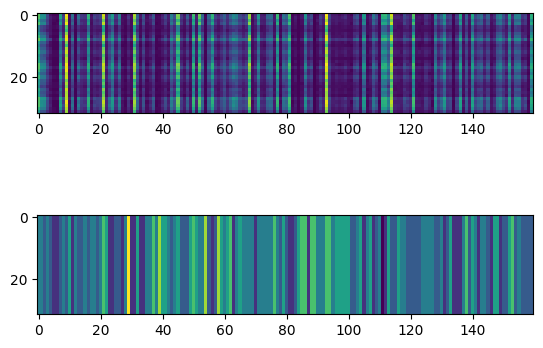

In [192]:
plt.subplot(2,1,1)
plt.imshow(thrid_160)
plt.subplot(2,1,2)
plt.imshow(four_960[:, :160])

## 5-1 Weight initalization 진행
- teacher model을 tf_efficientnetv2_l로 설정하여 똑같이 진행하였으나(initalization ratio 50%) 소스코드에 첨부하지 않음.

In [ ]:
from einops import reduce
from tqdm.auto import tqdm, trange
import timm
from efficientnet_pytorch import EfficientNet

def train(transform, transform_val, model_name, batchsize = 32):

    start_time = str(datetime.now().date().year) + "_" + str(datetime.now().date().month) + "_" +  \
         str(datetime.now().date().day).zfill(2) + "_" + str(datetime.now().hour).zfill(2) + "_" + \
         str(datetime.now().minute).zfill(2) + "_" + str(datetime.now().second).zfill(2)
    make_time_dir(start_time=start_time)
    #실험 재현을 위한 랜덤시드 고정
    set_seed(42)

    train_img_paths, train_labels = get_data(train_df)
    val_img_paths, val_labels = get_data(val_df)
    
    train_dataset = CustomDataset(train_img_paths, train_labels, transforms = transform)
    train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle=True, num_workers=4, drop_last = True)
    val_dataset = CustomDataset(val_img_paths, val_labels, transforms = transform_val)
    val_loader = DataLoader(val_dataset, batch_size = batchsize, shuffle=True, num_workers=4)

    n_epochs = 100
    model = EfficientNet.from_pretrained("efficientnet-b4", num_classes=8, in_channels = 1).to(device)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model).to(device)
    model.module.load_state_dict(torch.load('./Save_model/efficientnet-b4F.pt'))
    model = model.to(device)

    idx = [5, 6, 10, 12, 27, 28, 38, 39, 54, 78, 82, 84, 89, 100, 104, 106, 110, 124, 134, 158] # weight initialization
    student_model = timm.create_model(model_name, num_classes = 8, in_chans = 1, pretrained=True).to(device)
    student_model.load_state_dict(torch.load(
        './Save_model/2022_12_05_10_57_46_EFFb4_Train(256-224)_Cutmix25Mixup25_(284-256)_best/fold0_068_Accuracy is 94.72%.pt'
        ))

    with torch.no_grad():
        for i, e in enumerate(student_model.parameters()):
            if e.shape == torch.Size([360, 160, 1, 1]) and i == 184:
                for prune_idx in idx:
                    e[:, prune_idx, :, :] = torch.rand((360, 1, 1), requires_grad=True).to(device)
                    print("Weight initialization")

    if torch.cuda.device_count() > 1: student_model = nn.DataParallel(student_model).to(device)

    criterion = nn.CrossEntropyLoss()
    train_criterion = CutMixCriterion()
    optimizer = optim.AdamW(student_model.parameters(),lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
    #                     T_0 = 10, T_mult = 2, eta_min=1e-6) # 1e-6

    valid_loss_min = np.Inf # track change in validation loss
    valid_acc_max = 0 # track change in validation loss

    # keep track of training and validation loss
    train_loss = torch.zeros(n_epochs)
    valid_loss = torch.zeros(n_epochs)

    train_acc = torch.zeros(n_epochs)
    valid_acc = torch.zeros(n_epochs)

    early_stopcount = 0

    for e in range(0, n_epochs):
        student_model.train()   
        for data, labels in tqdm(train_loader):
            rand_num = np.random.rand()
            
            if rand_num > 0.75: data, (target1, target2, lam) = cutmix(data, labels)
            elif rand_num > 0.5: 
                data, target1, target2, lam = mixup_data(data, labels)
                data, target1, target2 = map(Variable, (data, target1, target2))

            data = reduce(data, 'b (c c1) h w -> b c h w', 'mean', c1=3)
            data = data.float().to(device) # labels.to(device) # move tensors to GPU if CUDA is available     
            if rand_num > 0.5: labels = (target1.to(device), target2.to(device), lam)
            else: labels = labels.to(device)

            optimizer.zero_grad() # clear the gradients of all optimized variables
            student_outputs = student_model(data) # forward pass: compute predicted outputs by passing inputs to the model
            teacher_outputs = model(data)

            if rand_num > 0.5: total_loss = knowledge_distillation_loss(student_outputs, labels, train_criterion, teacher_outputs)
            else: total_loss = knowledge_distillation_loss(student_outputs, labels, criterion, teacher_outputs)

            total_loss.backward()
            optimizer.step()
            train_loss[e] += total_loss.item() # update training loss

        train_loss[e] /= len(train_loader)
        
        with torch.no_grad(): 
            student_model.eval()
            for data, labels in tqdm(val_loader):
                data = reduce(data, 'b (c c1) h w -> b c h w', 'mean', c1=3)
                data, labels = data.float().to(device), labels.to(device) # move tensors to GPU if CUDA is available
                
                logits = student_model(data) # forward pass: compute predicted outputs by passing inputs to the model
                loss = criterion(logits, labels)  # calculate the batch loss
                valid_loss[e] += loss.item()  # update average validation loss 
                
                ps = F.softmax(logits, dim=1)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.reshape(top_class.shape)
                valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
                
        
        # calculate average losses
        valid_loss[e] /= len(val_loader)
        valid_acc[e] /= len(val_loader)
        
        scheduler.step(valid_loss[e])    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            e, train_loss[e], valid_loss[e]))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining accuracy: {} \tValidation accuracy: {:.6f}'.format(
            e, "No ACC in Train", valid_acc[e]))
        
        # save model if validation loss has decreased
        if valid_acc[e] >= valid_acc_max:
            print('Validation ACC increased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_acc_max, valid_acc[e]))
            # torch.save(student_model.module.state_dict(), './Save_model/' + model_name + 'B.pt') #모델파일이 저장되고자하는 경로 지정
            torch.save(student_model.module.state_dict(), f"Save_model/{start_time}/fold{i}_{e:03}_Accuracy is {valid_acc[e]:4.2%}.pt")

            valid_acc_max = valid_acc[e]
            early_stopcount = 0

        if early_stopcount >= 10:
            break

        early_stopcount+=1
    print(valid_acc_max)

In [ ]:
transform11 = A.Compose([
    A.Resize(width = 284, height = 284),
    A.RandomCrop(width = 256, height = 256),
    A.FancyPCA(0.5),
    # A.HorizontalFlip(p=0.5),
    # A.Cutout(p = 0.5),
    A.Rotate(limit=15),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std= [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

transform_val = A.Compose([
    A.Resize(width = 256, height = 256),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std = [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])


li = [transform11]
model_lists = ['nf_regnet_b1']

for i, tf in enumerate(li):
    for e, model_list in enumerate(model_lists):
        print(f"{i}th {e}=========================================")
        train(transform = tf, transform_val = transform_val, model_name = model_list)

0th 0=========================================
Loaded pretrained weights for efficientnet-b4
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization
Weight initialization


100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


Epoch: 0 	Training Loss: 0.858999 	Validation Loss: 0.272960
Epoch: 0 	Training accuracy: No ACC in Train 	Validation accuracy: 0.922950
Validation ACC increased (0.000000 --> 0.922950).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


Epoch: 1 	Training Loss: 0.851936 	Validation Loss: 0.206534
Epoch: 1 	Training accuracy: No ACC in Train 	Validation accuracy: 0.939777
Validation ACC increased (0.922950 --> 0.939777).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.75it/s]


Epoch: 2 	Training Loss: 0.887165 	Validation Loss: 0.248557
Epoch: 2 	Training accuracy: No ACC in Train 	Validation accuracy: 0.924975


100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


Epoch: 3 	Training Loss: 0.882987 	Validation Loss: 0.218646
Epoch: 3 	Training accuracy: No ACC in Train 	Validation accuracy: 0.936488


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


Epoch: 4 	Training Loss: 0.815669 	Validation Loss: 0.270510
Epoch: 4 	Training accuracy: No ACC in Train 	Validation accuracy: 0.933009


100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


Epoch: 5 	Training Loss: 0.846998 	Validation Loss: 0.258442
Epoch: 5 	Training accuracy: No ACC in Train 	Validation accuracy: 0.937943


100%|██████████| 38/38 [00:08<00:00,  4.75it/s]


Epoch: 6 	Training Loss: 0.839906 	Validation Loss: 0.216763
Epoch: 6 	Training accuracy: No ACC in Train 	Validation accuracy: 0.941865
Validation ACC increased (0.939777 --> 0.941865).  Saving model ...


100%|██████████| 38/38 [00:07<00:00,  4.85it/s]


Epoch: 7 	Training Loss: 0.880586 	Validation Loss: 0.283744
Epoch: 7 	Training accuracy: No ACC in Train 	Validation accuracy: 0.924785


100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Epoch: 8 	Training Loss: 0.845863 	Validation Loss: 0.227078
Epoch: 8 	Training accuracy: No ACC in Train 	Validation accuracy: 0.932819


100%|██████████| 38/38 [00:08<00:00,  4.70it/s]


Epoch: 9 	Training Loss: 0.814655 	Validation Loss: 0.257651
Epoch: 9 	Training accuracy: No ACC in Train 	Validation accuracy: 0.935855


100%|██████████| 38/38 [00:07<00:00,  4.87it/s]


Epoch: 10 	Training Loss: 0.863552 	Validation Loss: 0.239443
Epoch: 10 	Training accuracy: No ACC in Train 	Validation accuracy: 0.934653


100%|██████████| 38/38 [00:07<00:00,  4.75it/s]


Epoch: 11 	Training Loss: 0.837041 	Validation Loss: 0.225248
Epoch: 11 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942434
Validation ACC increased (0.941865 --> 0.942434).  Saving model ...


100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


Epoch: 12 	Training Loss: 0.774564 	Validation Loss: 0.263922
Epoch: 12 	Training accuracy: No ACC in Train 	Validation accuracy: 0.934274


100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


Epoch: 13 	Training Loss: 0.724991 	Validation Loss: 0.213661
Epoch: 13 	Training accuracy: No ACC in Train 	Validation accuracy: 0.944079
Validation ACC increased (0.942434 --> 0.944079).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


Epoch: 14 	Training Loss: 0.679218 	Validation Loss: 0.214315
Epoch: 14 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942434


100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Epoch: 15 	Training Loss: 0.695824 	Validation Loss: 0.201372
Epoch: 15 	Training accuracy: No ACC in Train 	Validation accuracy: 0.945724
Validation ACC increased (0.944079 --> 0.945724).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


Epoch: 16 	Training Loss: 0.729175 	Validation Loss: 0.211536
Epoch: 16 	Training accuracy: No ACC in Train 	Validation accuracy: 0.942687


100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


Epoch: 17 	Training Loss: 0.708238 	Validation Loss: 0.198109
Epoch: 17 	Training accuracy: No ACC in Train 	Validation accuracy: 0.948191
Validation ACC increased (0.945724 --> 0.948191).  Saving model ...


100%|██████████| 38/38 [00:07<00:00,  4.81it/s]


Epoch: 18 	Training Loss: 0.652715 	Validation Loss: 0.197071
Epoch: 18 	Training accuracy: No ACC in Train 	Validation accuracy: 0.948001


100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


Epoch: 19 	Training Loss: 0.652313 	Validation Loss: 0.196349
Epoch: 19 	Training accuracy: No ACC in Train 	Validation accuracy: 0.947811


100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


Epoch: 20 	Training Loss: 0.717071 	Validation Loss: 0.194957
Epoch: 20 	Training accuracy: No ACC in Train 	Validation accuracy: 0.946799


100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


Epoch: 21 	Training Loss: 0.679108 	Validation Loss: 0.188611
Epoch: 21 	Training accuracy: No ACC in Train 	Validation accuracy: 0.948634
Validation ACC increased (0.948191 --> 0.948634).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


Epoch: 22 	Training Loss: 0.663614 	Validation Loss: 0.189943
Epoch: 22 	Training accuracy: No ACC in Train 	Validation accuracy: 0.948191


100%|██████████| 38/38 [00:08<00:00,  4.72it/s]


Epoch: 23 	Training Loss: 0.691982 	Validation Loss: 0.180671
Epoch: 23 	Training accuracy: No ACC in Train 	Validation accuracy: 0.948823
Validation ACC increased (0.948634 --> 0.948823).  Saving model ...


100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


Epoch: 24 	Training Loss: 0.647131 	Validation Loss: 0.189440
Epoch: 24 	Training accuracy: No ACC in Train 	Validation accuracy: 0.946799


100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Epoch: 25 	Training Loss: 0.653556 	Validation Loss: 0.188414
Epoch: 25 	Training accuracy: No ACC in Train 	Validation accuracy: 0.946546


100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


Epoch: 26 	Training Loss: 0.650178 	Validation Loss: 0.188560
Epoch: 26 	Training accuracy: No ACC in Train 	Validation accuracy: 0.946546


100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


Epoch: 27 	Training Loss: 0.659425 	Validation Loss: 0.188336
Epoch: 27 	Training accuracy: No ACC in Train 	Validation accuracy: 0.948191


100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch: 28 	Training Loss: 0.627913 	Validation Loss: 0.190023
Epoch: 28 	Training accuracy: No ACC in Train 	Validation accuracy: 0.947368


100%|██████████| 38/38 [00:08<00:00,  4.54it/s]


Epoch: 29 	Training Loss: 0.667005 	Validation Loss: 0.194115
Epoch: 29 	Training accuracy: No ACC in Train 	Validation accuracy: 0.945724


100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


Epoch: 30 	Training Loss: 0.664075 	Validation Loss: 0.189418
Epoch: 30 	Training accuracy: No ACC in Train 	Validation accuracy: 0.947368


100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


Epoch: 31 	Training Loss: 0.643081 	Validation Loss: 0.190582
Epoch: 31 	Training accuracy: No ACC in Train 	Validation accuracy: 0.945977


100%|██████████| 38/38 [00:08<00:00,  4.63it/s]


Epoch: 32 	Training Loss: 0.689310 	Validation Loss: 0.184907
Epoch: 32 	Training accuracy: No ACC in Train 	Validation accuracy: 0.946356


100%|██████████| 38/38 [00:07<00:00,  4.87it/s]


Epoch: 33 	Training Loss: 0.653098 	Validation Loss: 0.189641
Epoch: 33 	Training accuracy: No ACC in Train 	Validation accuracy: 0.946989
tensor(0.9488)


# 5. Preparing Test data

In [ ]:
test_df = pd.read_csv('./sample_submission.csv')
test_img_paths = get_data(test_df,test=True)

test_dataset = CustomDataset(test_img_paths,transforms=transform_val)
test_loader = DataLoader(test_dataset, batch_size=64,shuffle=False, num_workers=4)

In [ ]:
transform_val = A.Compose([
    A.Resize(width = 256, height = 256),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std = [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

In [23]:
pred = []

with torch.no_grad(): 
    model.eval()
    for images in tqdm(test_loader):
        images = reduce(images, 'b (c c1) h w -> b c h w', 'mean', c1=3)
        images = images.to(device)
        logits = model(images)
        pred+=logits.argmax(1).detach().cpu().numpy().tolist()

100%|██████████| 82/82 [00:22<00:00,  3.69it/s]


# 7. Printing GFLOPs
- 아래 코드 및 결과 스크린샷 보고서에 추가 필수

In [24]:
# !pip install thop
from thop import profile
import torch
# Creates once at the beginning of training
# scaler = torch.cuda.amp.GradScaler()

inputs = torch.randn(1, 1, 256, 256).to(device) # 자신의 model input size
macs, params = profile(model.module, inputs=(inputs, ))
flops = macs*2
gflops = round(flops/1000000000,7)

print("내 모델의 FLOPs : ",gflops, "GFLOP")

[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
내 모델의 FLOPs :  0.0092865 GFLOP




# 8. Make submission
- 제출 csv파일명 변경 금지

In [25]:
# predict result로 제출 csv 작성
submission = pd.read_csv("./sample_submission.csv")
submission["Plane"] = pred
file_name=f"./submission_{gflops}.csv"

submission.to_csv(file_name, index = False)

## inference

In [90]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=8)

Loaded pretrained weights for efficientnet-b2


In [63]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

transform_val = A.Compose([
    A.Resize(width = 256, height = 256),
    A.Normalize(mean = [0.1776098, 0.1776098, 0.1776098], std = [0.037073515, 0.037073515, 0.037073515]),
    ToTensorV2(p=1.0)
])

model_name = "tf_efficientnetv2_l"
model = timm.create_model(model_name, num_classes=8, in_chans = 1, pretrained = True).to(device)
model = nn.DataParallel(model)
model.module.load_state_dict(torch.load('./Save_model/tf_efficientnetv2_lC.pt'))

set_seed(42)
train_dataset = CustomDataset(train_img_paths, train_labels, transforms = transform_val)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True, num_workers=4, drop_last = True)
val_dataset = CustomDataset(val_img_paths, val_labels, transforms = transform_val)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle=True, num_workers=4)

pred = []
mat = np.zeros((8,8))

with torch.no_grad(): 
    model.eval()
    for images, labels in tqdm(val_loader):
        images = reduce(images, 'b (c c1) h w -> b c h w', 'mean', c1=3)
        images = images.to(device)
        logits = model(images)
        pred=logits.argmax(1).detach().cpu().numpy().tolist()
        for p, l in zip(pred, labels):
            mat[p, l]+=1

100%|██████████| 76/76 [00:32<00:00,  2.36it/s]


In [64]:
mat # tf_efficientnetv2_l

array([[ 71.,   0.,   0.,   0.,   0.,   0.,   0.,   7.],
       [  0., 174.,  23.,   0.,   0.,   0.,   0.,   3.],
       [  0.,   0.,  52.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,  58.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0., 100.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0., 211.,   0.,   3.],
       [  0.,   0.,   0.,   0.,   0.,   0., 196.,   2.],
       [  0.,   1.,   0.,   1.,   3.,   1.,   0., 301.]])

In [62]:
ori_mat # efficientnet b4

array([[ 70.,   0.,   0.,   0.,   0.,   0.,   0.,   6.],
       [  0., 165.,   4.,   8.,   0.,   0.,   0.,   6.],
       [  0.,   4.,  71.,   0.,   0.,   0.,   0.,   2.],
       [  0.,   6.,   0.,  51.,   0.,   0.,   0.,   2.],
       [  0.,   0.,   0.,   0.,  98.,   0.,   0.,   6.],
       [  0.,   0.,   0.,   0.,   0., 210.,   0.,   8.],
       [  0.,   0.,   0.,   0.,   0.,   0., 196.,   2.],
       [  1.,   0.,   0.,   0.,   5.,   2.,   0., 287.]])

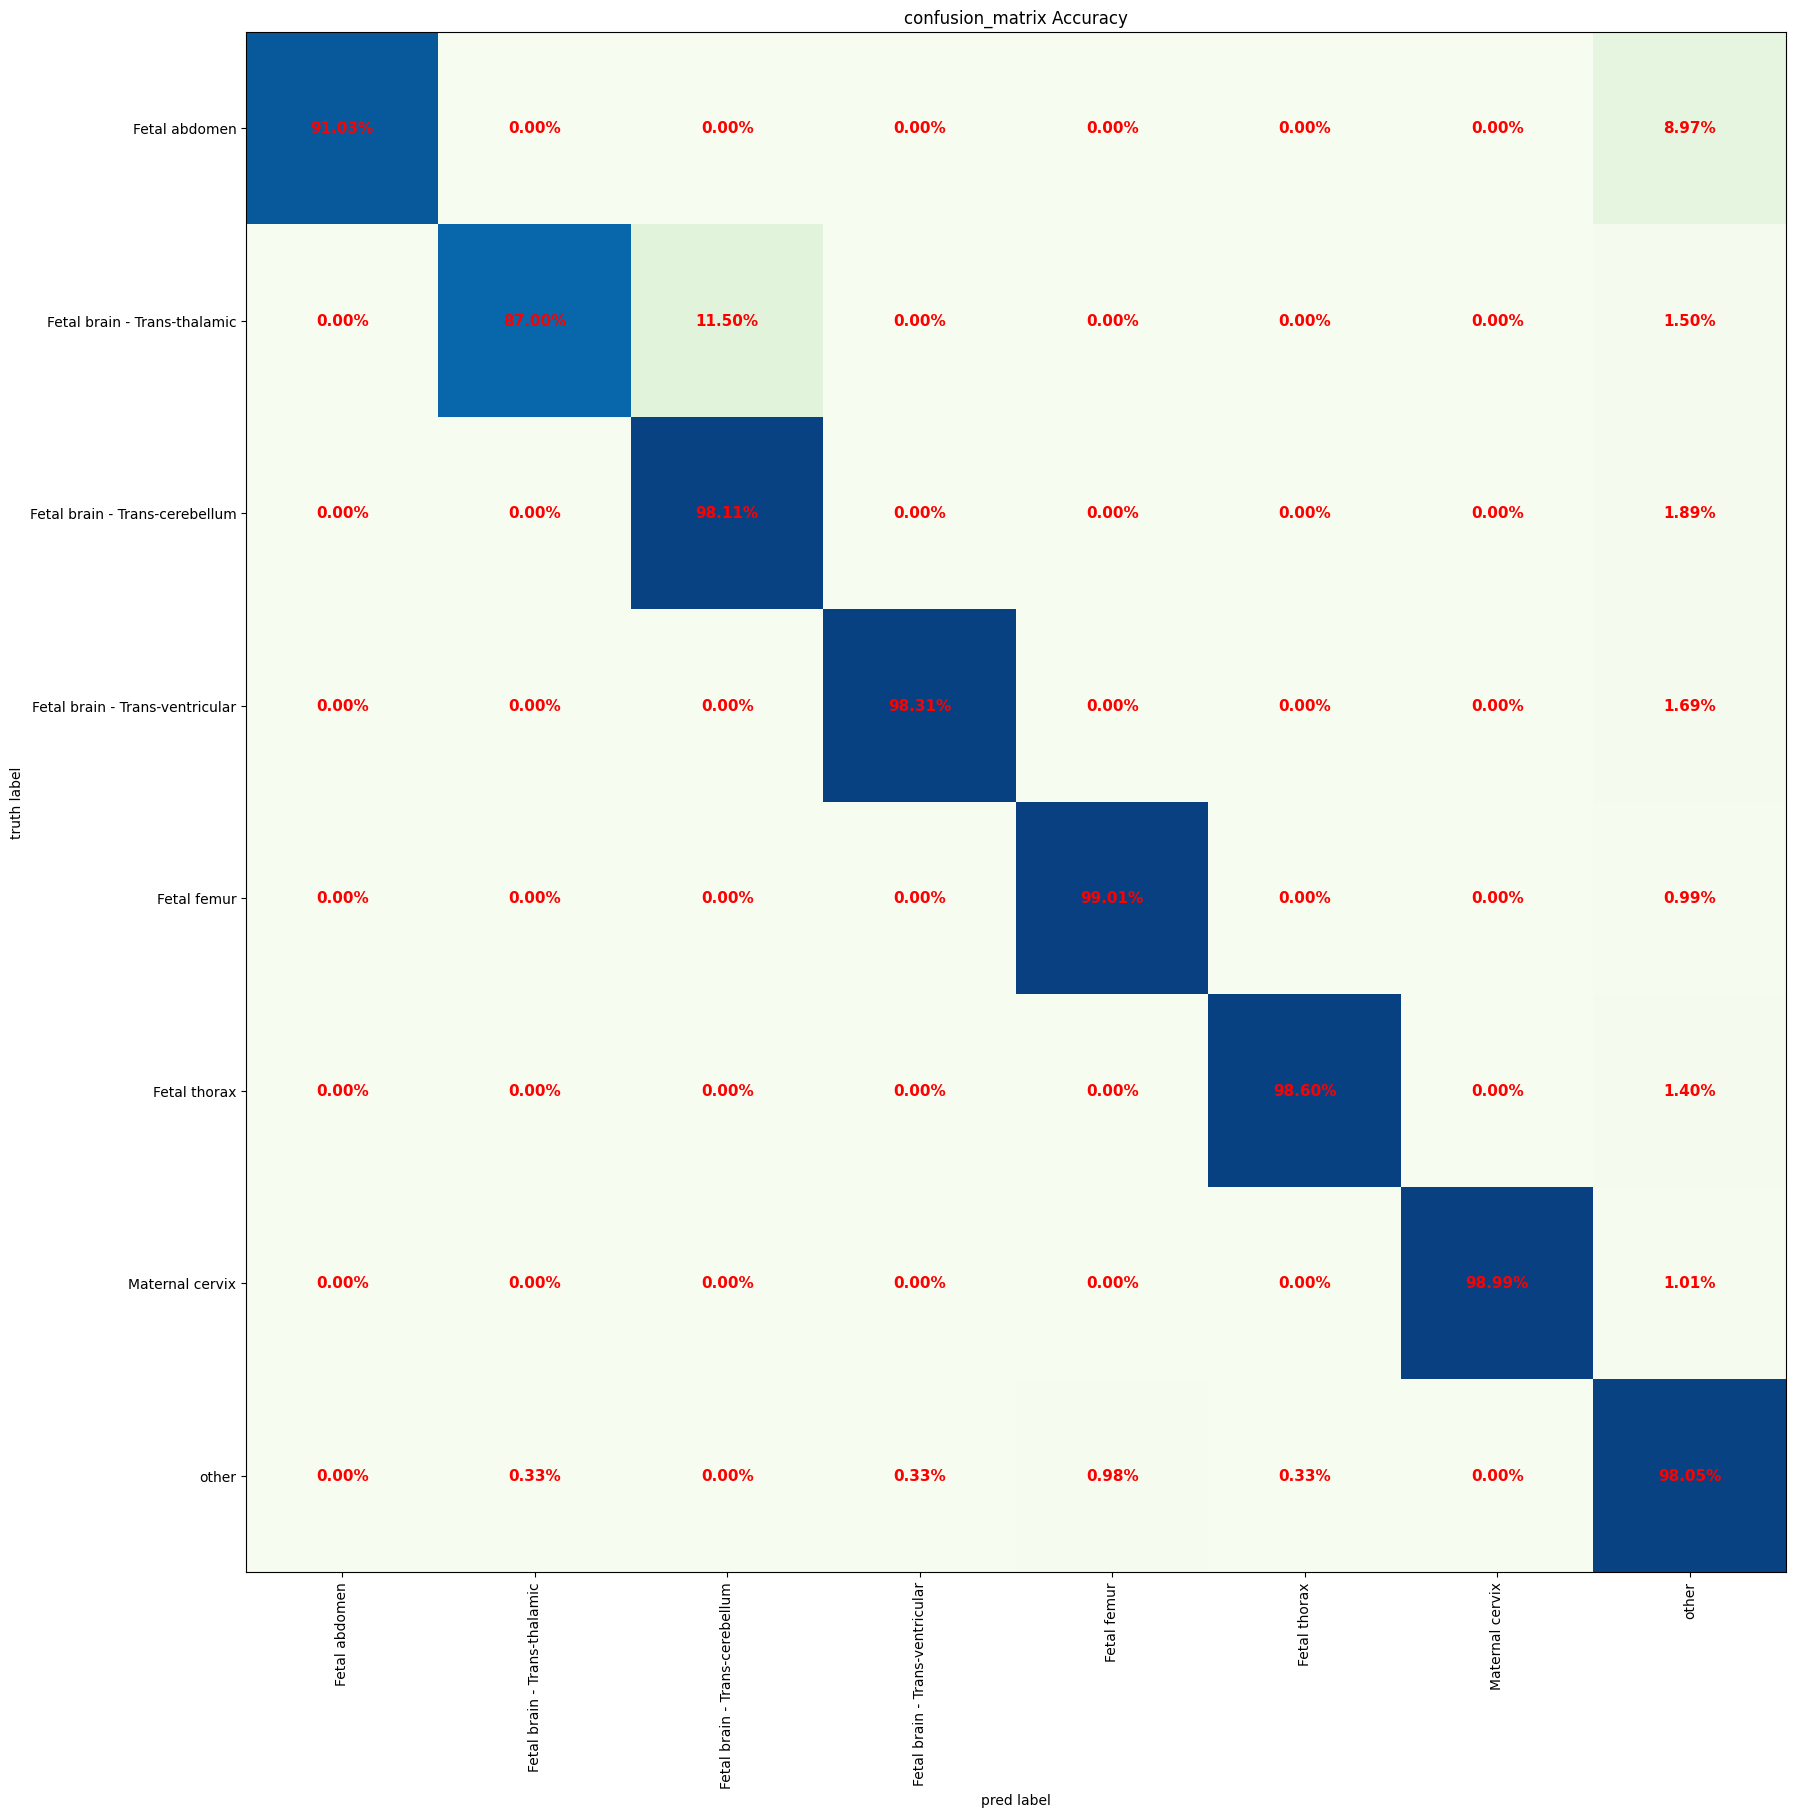

In [ ]:
plt.figure(figsize = (20,20))
import einops
c = mat/einops.repeat(np.sum(mat, axis = 1), 'w-> w h', h = 8)

classes = ['Fetal abdomen', 'Fetal brain - Trans-thalamic', 'Fetal brain - Trans-cerebellum',
            'Fetal brain - Trans-ventricular', 'Fetal femur', 'Fetal thorax',
            'Maternal cervix', 'other']
plt.imshow(c, cmap='GnBu')         
for (i, j), z in np.ndenumerate(c):
    # print(i, j, z)
    plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontsize=11, fontweight='bold')
    plt.title('confusion_matrix Accuracy')
    plt.xticks(np.arange(0, 8), classes, rotation = 90)
    plt.yticks(np.arange(0, 8), classes)
    plt.xlabel("pred label")
    plt.ylabel("truth label")


## pytorch efficientnet b4 Confusin Matrix

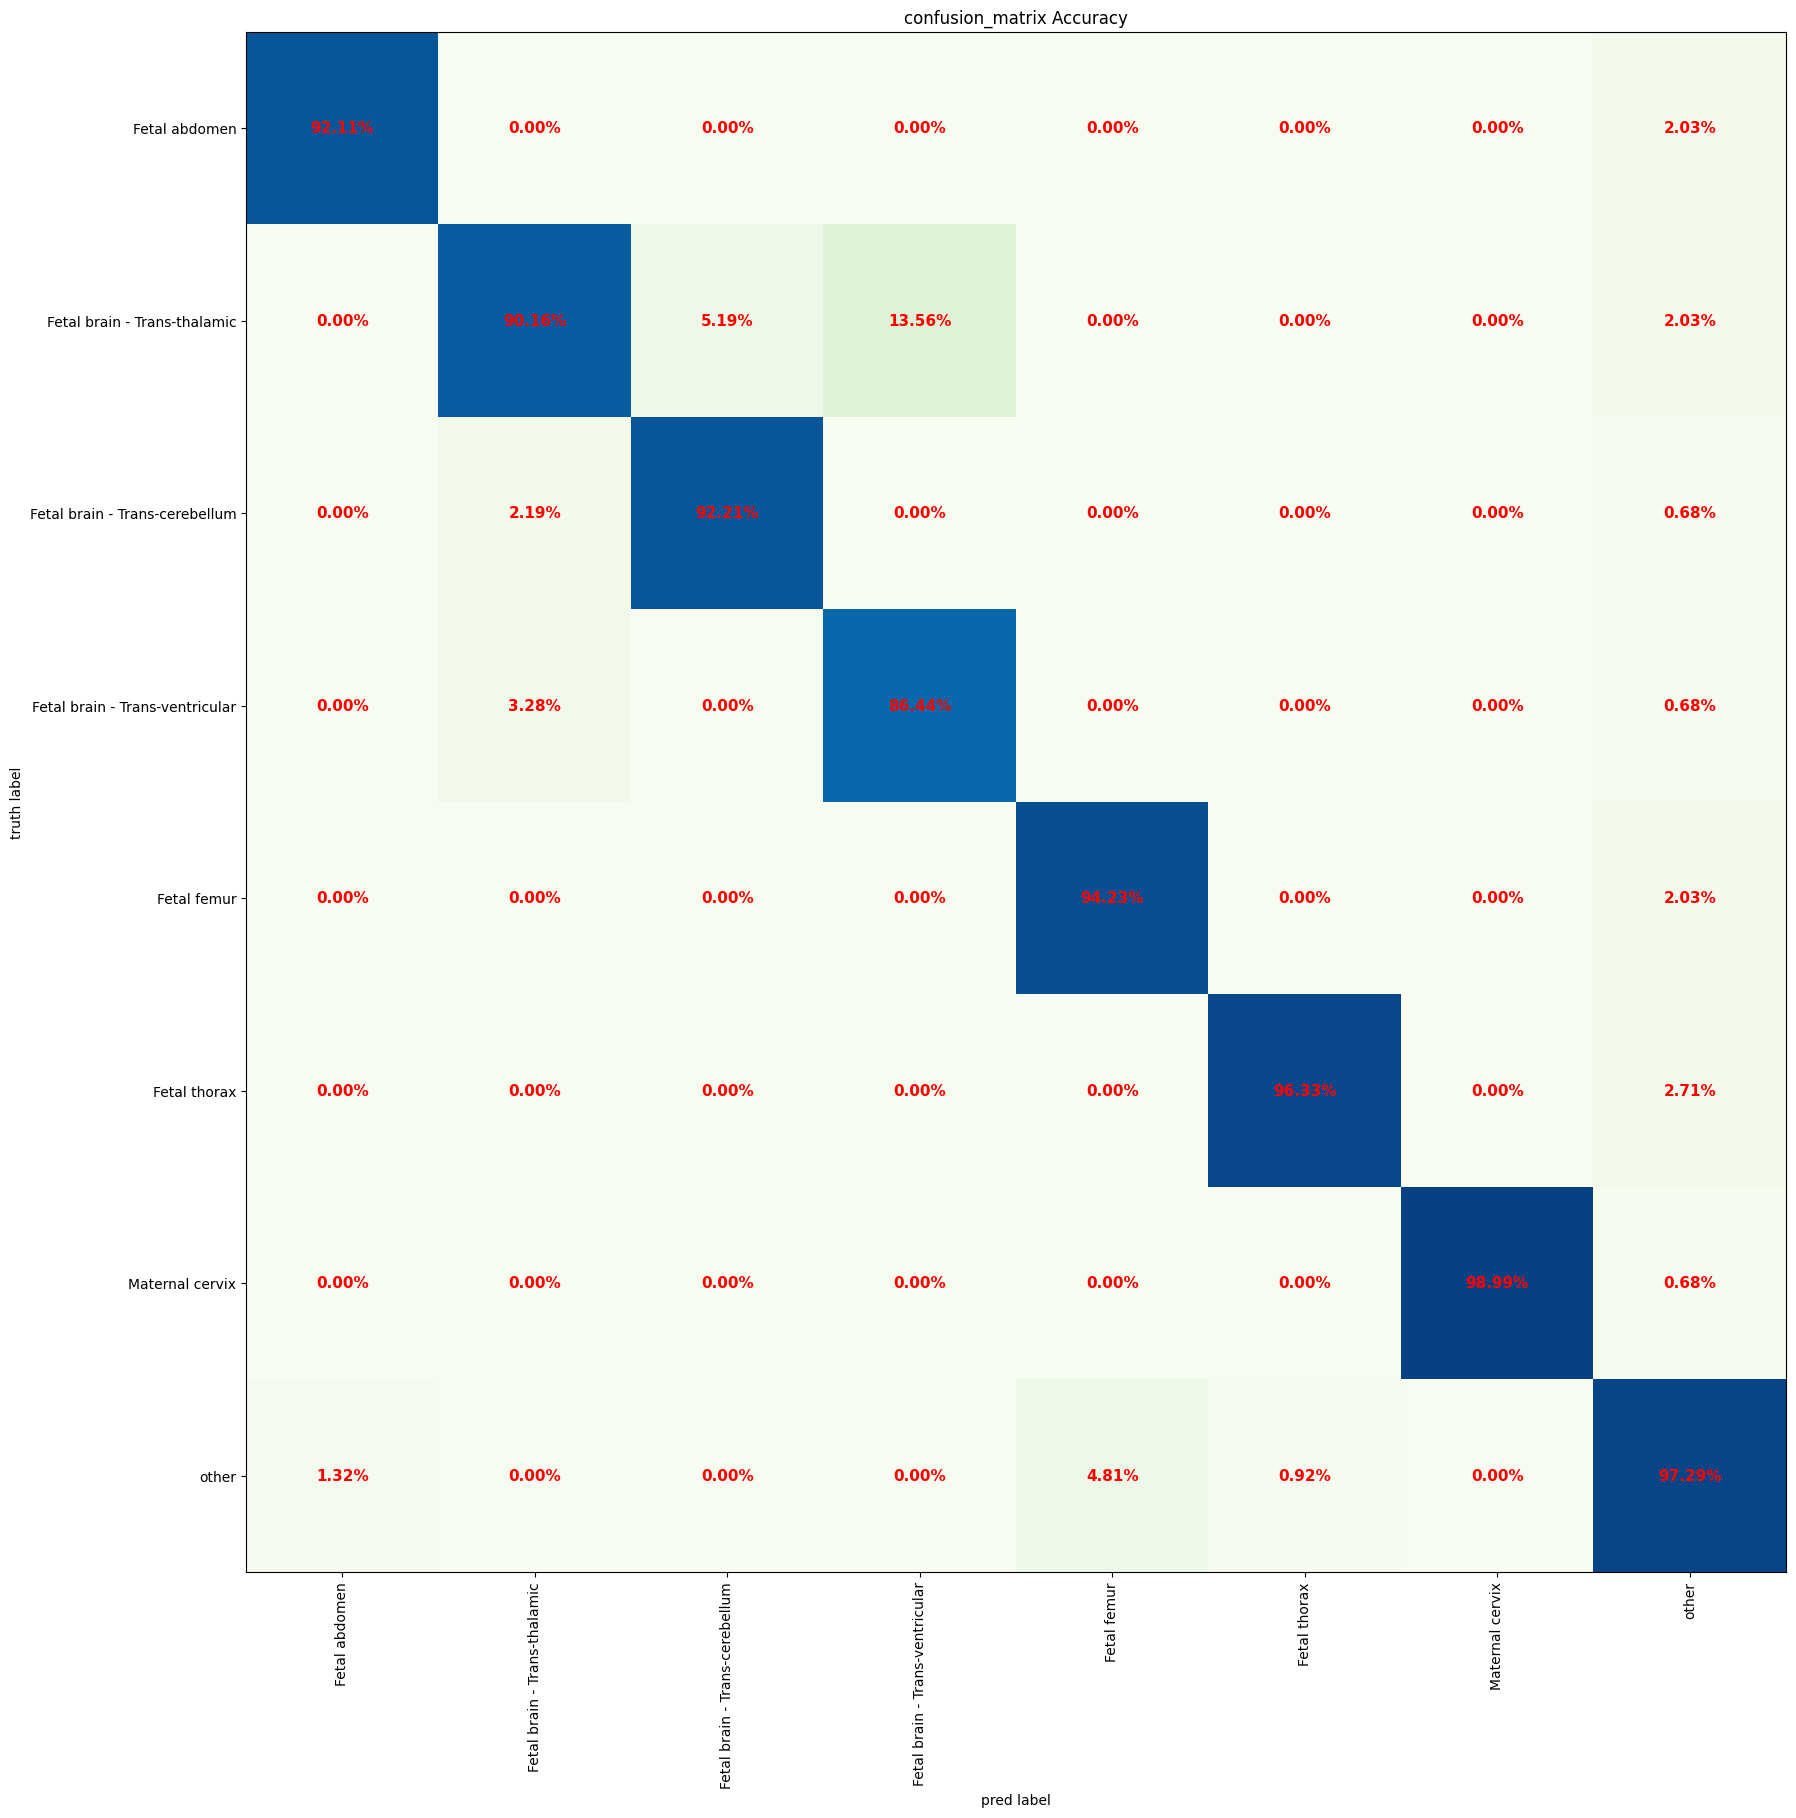

In [ ]:
plt.figure(figsize = (20,20))
c = (ori_mat/ori_mat.sum(axis=1))
classes = ['Fetal abdomen', 'Fetal brain - Trans-thalamic', 'Fetal brain - Trans-cerebellum',
            'Fetal brain - Trans-ventricular', 'Fetal femur', 'Fetal thorax',
            'Maternal cervix', 'other']
plt.imshow(c, cmap='GnBu')         
for (i, j), z in np.ndenumerate(c):
    # print(i, j, z)
    plt.text(j, i, '%.2f%%' % (z * 100), ha='center', va='center', color='Red', fontsize=11, fontweight='bold')
    plt.title('confusion_matrix Accuracy')
    plt.xticks(np.arange(0, 8), classes, rotation = 90)
    plt.yticks(np.arange(0, 8), classes)
    plt.xlabel("pred label")
    plt.ylabel("truth label")
